**Prediction of Wine Quality based on its Manufacturing Ingredients**

## 1. Data Importing and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from pprint import pprint
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay


/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
df =  pd.read_csv('https://raw.githubusercontent.com/rjrahul24/AppliedML-Project/main/data/wine_quality_pre.csv',sep = ",")
df.head()

,Unnamed: 0,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good
0,0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
4,4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0


## 2. Data Split and Preparation

In [4]:
X = df[['type', 'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density','pH','sulphates','alcohol']]
y = df['good']

In [5]:
y.value_counts()

0    5192
1    1271
Name: good, dtype: int64

In [25]:
# Split into Dev (80%) and Test (20%) Datasets, Random Forest doesn't need separate validation dataset
X_dev, X_test, y_dev, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42, stratify=y)

#### Use SMOTE to handle imbalanced dataset

In [7]:
print('development data distribution of labels before SMOTE: ')
y_dev.value_counts()

development data distribution of labels before SMOTE: 


0    4153
1    1017
Name: good, dtype: int64

In [8]:
smote = SMOTE()
X_dev_SMOTE, y_dev_SMOTE = smote.fit_resample(X_dev, y_dev)
print(f'development data distribution of labels after SMOTE:')
y_dev_SMOTE.value_counts()

development data distribution of labels after SMOTE:


1    4153
0    4153
Name: good, dtype: int64

In [9]:
X_dev = X_dev_SMOTE
y_dev = y_dev_SMOTE

**Pre-processing**

No scaling needed for random forest.

## 3. Model Selection, Training
### Dummy Classifier
To define baseline performance, we began with a dummy classifier. 

In [10]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy='most_frequent',random_state=42)
dummy_classifier.fit(X_dev,y_dev)
acc_baseline = dummy_classifier.score(X_test,y_test)
print("Baseline Accuracy = ", acc_baseline)

Baseline Accuracy =  0.8035576179427688


### Random Forest
No tuning


In [11]:
rf = RandomForestClassifier(n_jobs = -1)
rf.fit(X_dev, y_dev)

RandomForestClassifier(n_jobs=-1)

In [26]:
rf = RandomForestClassifier(n_jobs = -1)
rf.fit(X_dev, y_dev)
rf_pred = rf.predict(X_test)

recall = recall_score(y_test,rf_pred)
precision = precision_score(y_test,rf_pred)

print(f'Accuracy: {accuracy_score(y_test,rf_pred)}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F-1 Score: {f1_score(y_test,rf_pred)}')

Accuracy: 0.8963650425367363
Recall: 0.5905511811023622
Precision: 0.8333333333333334
F-1 Score: 0.6912442396313363


In [12]:
rf_pred = rf.predict(X_test)

recall = recall_score(y_test,rf_pred)
precision = precision_score(y_test,rf_pred)

print(f'Accuracy: {accuracy_score(y_test,rf_pred)}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F-1 Score: {f1_score(y_test,rf_pred)}')

Accuracy: 0.8654292343387471
Recall: 0.7677165354330708
Precision: 0.6290322580645161
F-1 Score: 0.6914893617021277


/Users/yuezhang/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


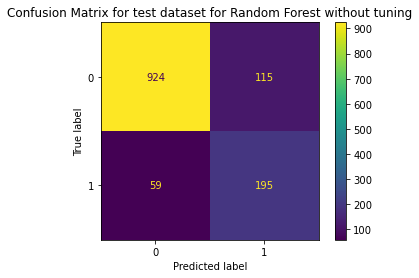

In [13]:
# Making the Confusion Matrix
plot_confusion_matrix(rf, X_test, y_test)  
plt.title("Confusion Matrix for test dataset for Random Forest without tuning")
plt.show()

In [14]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Tuning hyperparameters

In [15]:
parameter_grid = {'n_estimators':[100, 250, 400],
                  'max_depth':[5, 10, 15]}

rf_2 = make_pipeline(
    GridSearchCV(RandomForestClassifier(n_jobs = -1,warm_start=True), 
                 parameter_grid, 
                 cv=5, 
                 n_jobs=-1
                 )
)

rf_2.fit(X_dev, y_dev)

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(n_jobs=-1,
                                                               warm_start=True),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10, 15],
                                          'n_estimators': [100, 250, 400]}))])

In [16]:
rf_2_grid_search_results = rf_2.named_steps['gridsearchcv']

print(f'Best Score:{rf_2_grid_search_results.best_score_:0.5f}')
print(f'Best Params:{rf_2_grid_search_results.best_params_ }')
print(f'Test score:{rf_2.score(X_test,y_test):0.5f}')

Best Score:0.89514
Best Params:{'max_depth': 15, 'n_estimators': 250}
Test score:0.85692


/Users/yuezhang/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


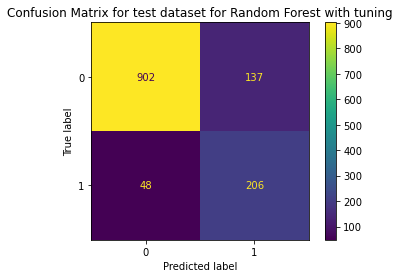

In [17]:
# Making the Confusion Matrix
plot_confusion_matrix(rf_2, X_test, y_test)  
plt.title("Confusion Matrix for test dataset for Random Forest with tuning")
plt.show()

In [18]:
pickle.dump(rf_2, open('../models/RandomForest.sav', 'wb'))

### XGBoost

In [19]:
# start3 = time.time()
parameter_grid = {'n_estimators':[100, 250, 400],
                  'max_depth':[5, 10, 15],
                  'learning_rate':[0.05,0.1,0.15]}
eval_metric= ['logloss']
xgb = make_pipeline(
    GridSearchCV(XGBClassifier(n_jobs = -1, eval_metric='logloss'), 
                 parameter_grid, 
                 cv=5, 
                 n_jobs=-1))

xgb.fit(X_dev, y_dev)
# end3 = time.time()

/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
               

In [20]:
grid_search_XGB = xgb.named_steps["gridsearchcv"]
print(f'XGBoost Best Score:{grid_search_XGB.best_score_:0.5f}')
print(f'XGBoost Best Params:{grid_search_XGB.best_params_ }')
print(f'XGBoost Test score:{xgb.score(X_test,y_test):0.5f}')

XGBoost Best Score:0.90936
XGBoost Best Params:{'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 400}
XGBoost Test score:0.88631


In [21]:
xgb_y_pred = xgb.predict(X_test)
recall = recall_score(y_test,xgb_y_pred), 
precision = precision_score(y_test,xgb_y_pred)
print(f'Accuracy: {accuracy_score(y_test,xgb_y_pred)}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F-1 Score: {f1_score(y_test,xgb_y_pred)}')

Accuracy: 0.8863109048723898
Recall: (0.6850393700787402,)
Precision: 0.7219917012448133
F-1 Score: 0.703030303030303


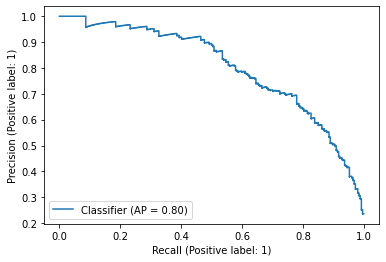

In [22]:
probs = xgb.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision);

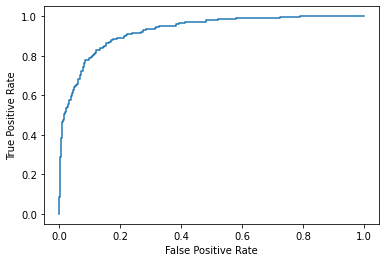

In [23]:
fp, tp, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fp, tpr = tp)
disp.plot()

In [24]:
pickle.dump(rf_2, open('../models/XGBoost.sav', 'wb'))

/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (p

/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (p

/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (p

/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (p

/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (p

/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (p

/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (p

/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/yuezhang/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (p

### LightGBM